### This script contains the following:
#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [20]:
#import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings 
from pylab import rcParams

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') 

In [3]:
# Configure API key
quandl.ApiConfig.api_key = '67ebGzhpRon5ivJmnL5Y'

In [4]:
# Importing the Federal Reserve Economic Data "Real Gross Domestic Product" variable.
data = quandl.get('FRED/GDPC1')

In [5]:
#view data
data.head(5)

,Value
Date,
1947-01-01,2034.450
1947-04-01,2029.024
1947-07-01,2024.834
1947-10-01,2056.508
1948-01-01,2087.442


In [6]:
#check the shape
data.shape

(300, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

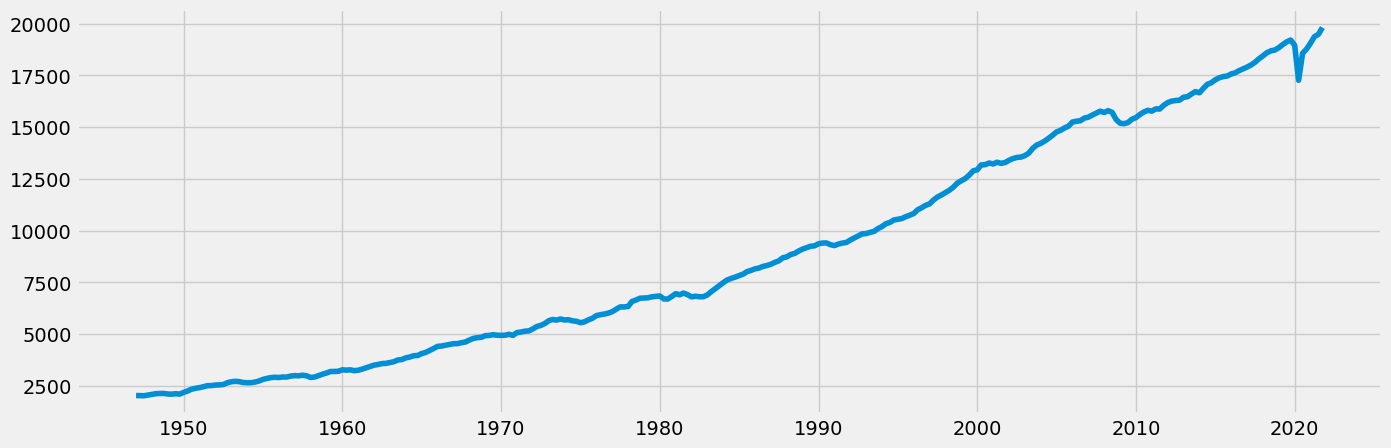

In [9]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [11]:
#view the data
data_2.head()

,Date,Value
0,1947-01-01,2034.450
1,1947-04-01,2029.024
2,1947-07-01,2024.834
3,1947-10-01,2056.508
4,1948-01-01,2087.442


In [12]:
#create a subset for a certain date range
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [13]:
#check the shape of the new dataframe
data_sub.shape

(162, 2)

In [14]:
#Check the data frame
data_sub.head()

,Date,Value
132,1980-01-01,6842.024
133,1980-04-01,6701.046
134,1980-07-01,6693.082
135,1980-10-01,6817.903
136,1981-01-01,6951.495


In [15]:
# Set the "Date" column as the index
from datetime import datetime
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6842.024
1980-04-01,6701.046
1980-07-01,6693.082
1980-10-01,6817.903
1981-01-01,6951.495


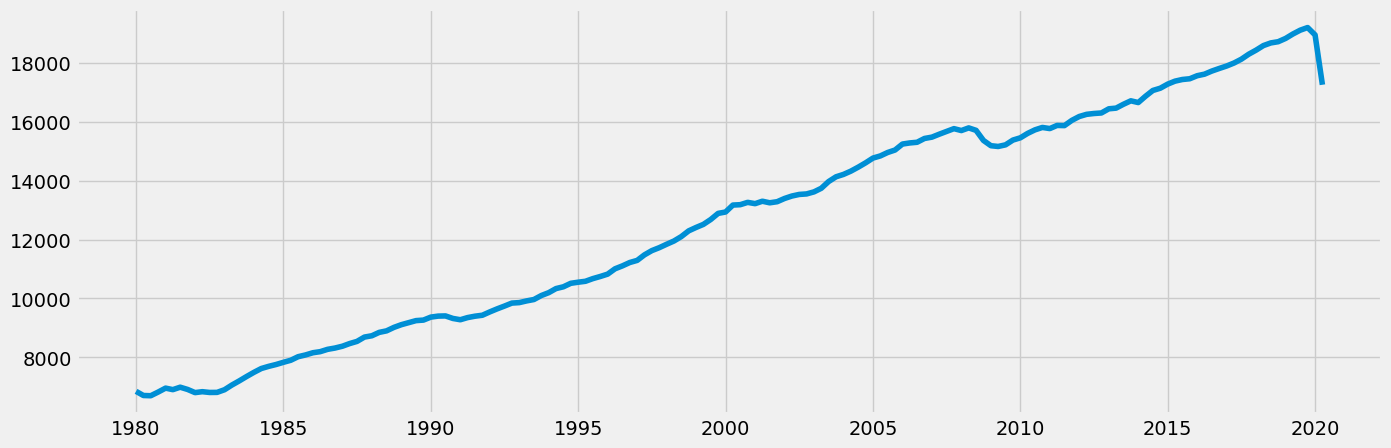

In [16]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [18]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

### 3. Time-series analysis: decomposition

In [19]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
rcParams['figure.figsize'] = 18, 7

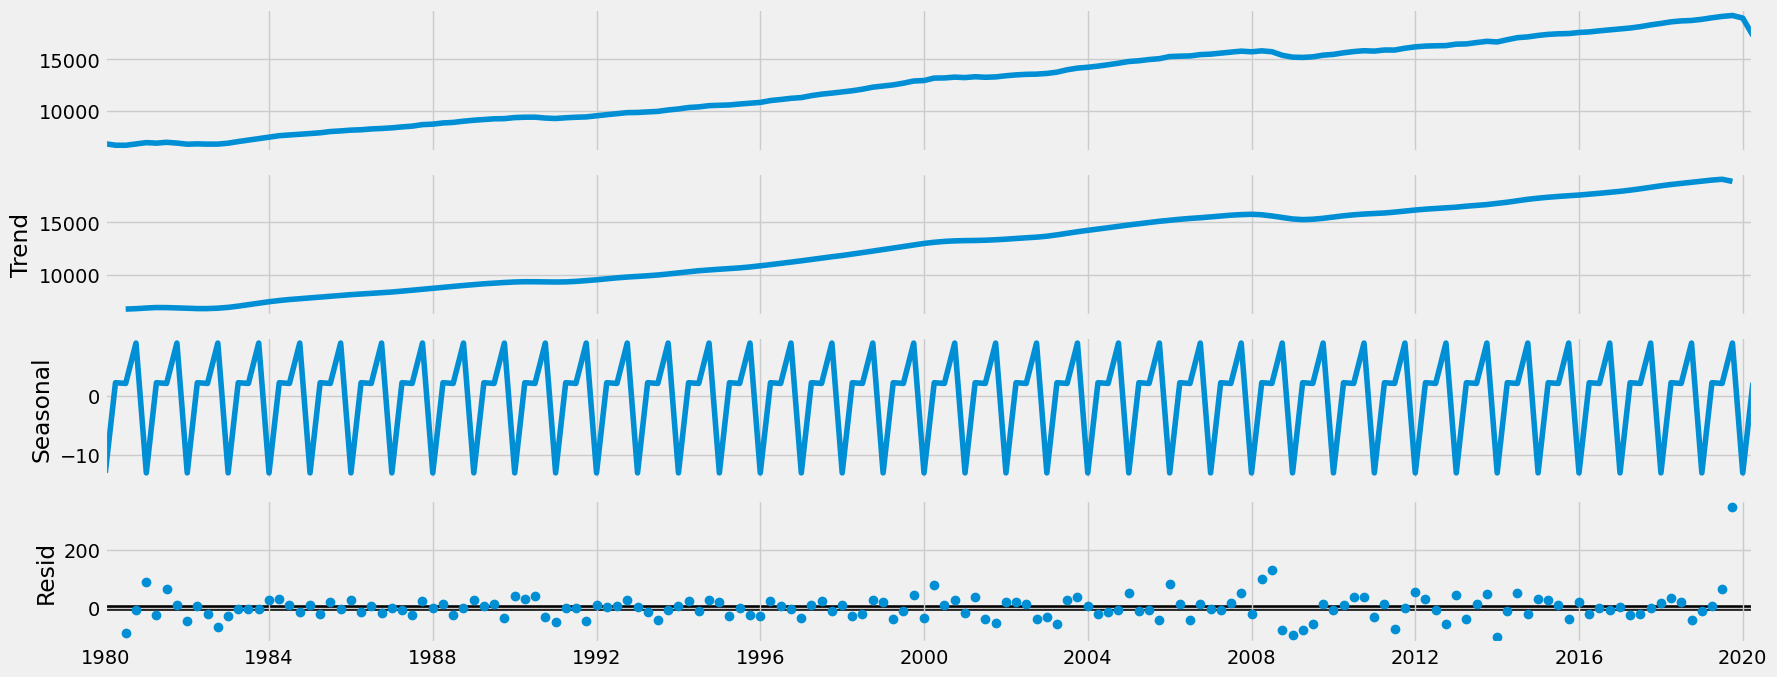

In [22]:
# Plot the separate components
decomposition.plot()
plt.show()

##### Observations:
From the graphic plot we can see that there is a upward linear trend over the years in domestic product, with a slight increase in 2008. We can also see there is a seasonality present in the data that is represented by a a spike and drop that occurs at regular intervals. The residual chart shows the noise of the data, which there is not a lot of because the plots are mostly centered around zero.

### 4. Testing for stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function
def dickey_fuller(timeseries): # Define the function
# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)
# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.927298
p-value                          0.319330
Number of Lags Used              1.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


The statistic test is larger than the critical value so we need to stationarize the data.

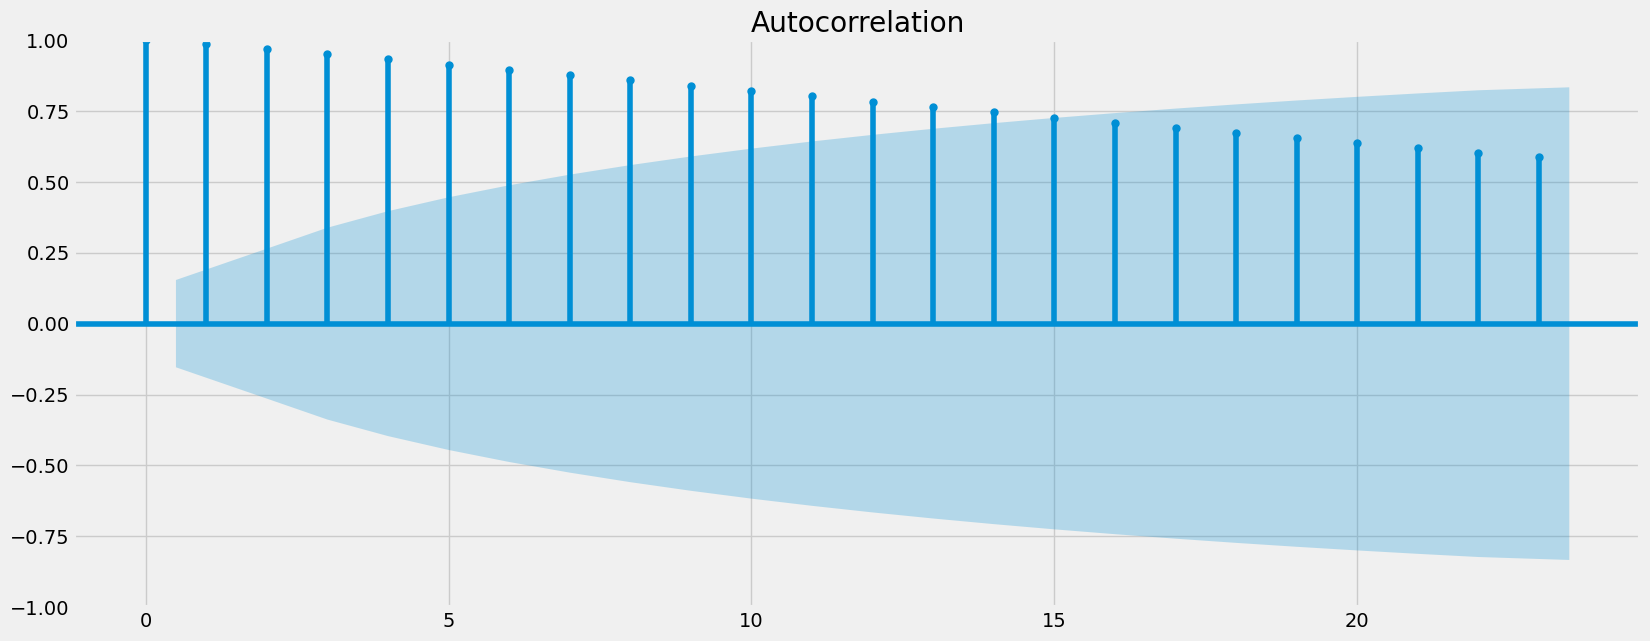

In [24]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots
plot_acf(data_sub)
plt.show()

There are a lot of lags above the confidence interval edge, which means there are many lags significantly correlated with each other (or there is a lot of autocorrelated data, supporting the result of the Dickey-Fuller test)

### 5. Stationarizing the Federal Reserve Economic Data

In [25]:
data_diff = data_sub - data_sub.shift(1) 

In [26]:
data_diff.dropna(inplace = True) # remove the missing values that came about as a result of the differencing.
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [27]:
data_diff.head()

,Value
datetime,
1980-04-01,-140.978
1980-07-01,-7.964
1980-10-01,124.821
1981-01-01,133.592
1981-04-01,-51.515


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

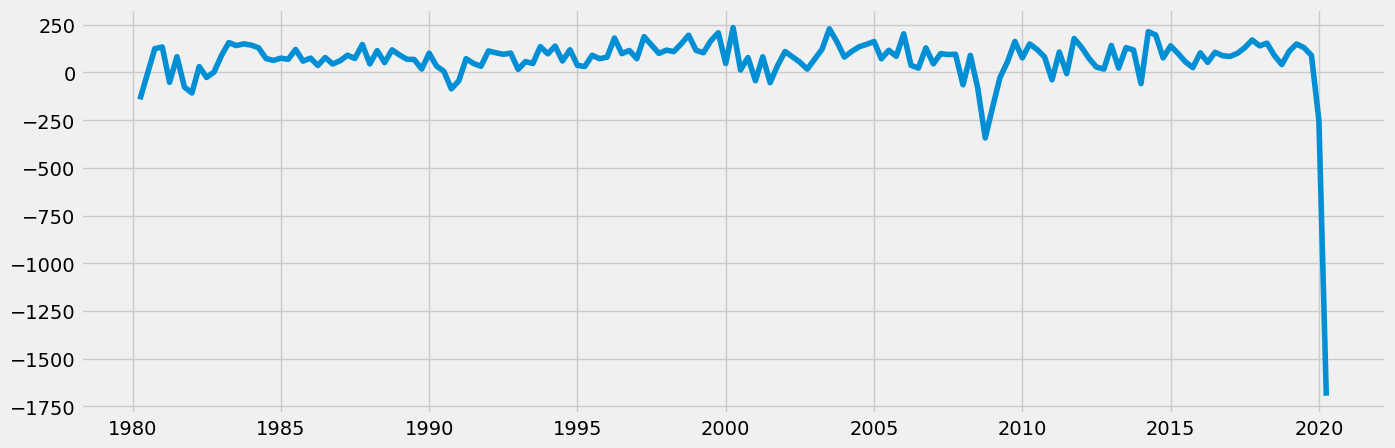

In [29]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -0.848092
p-value                          0.804586
Number of Lags Used              0.000000
Number of Observations Used    160.000000
Critical Value (1%)             -3.471896
Critical Value (5%)             -2.879780
Critical Value (10%)            -2.576495
dtype: float64


##### Observations:
After stationarizing the data test statistic is still larger than all 3 of the critical values, and the p-value is greater than 0.05 meaning we can not reject the nulll hypothesis. 

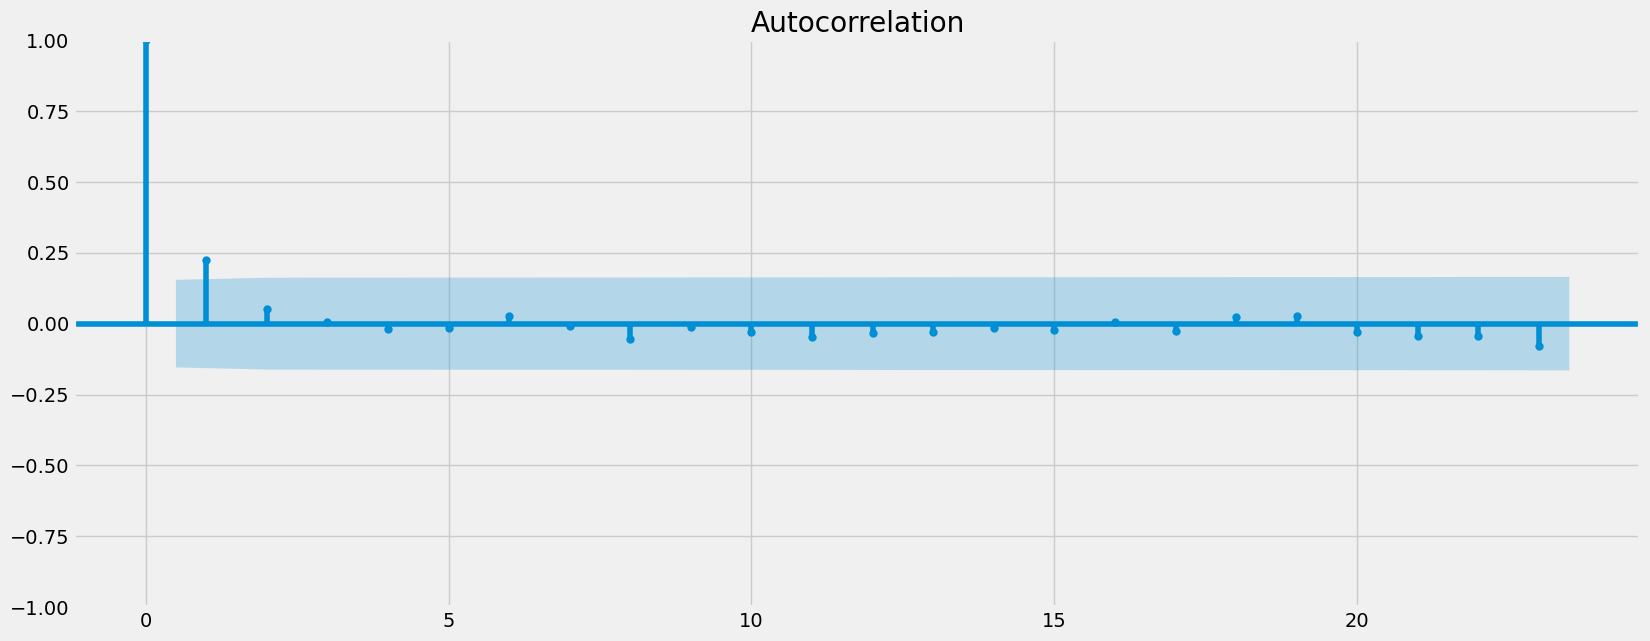

In [45]:
plot_acf(data_diff)
plt.show()

In [39]:
#Perform another round of differencing because the data is still not stationary.
data_diff2 = data_diff - data_diff.shift(1) 

In [40]:
data_diff2.dropna(inplace = True) 

In [41]:
data_diff2.head()

,Value
datetime,
1980-07-01,133.014
1980-10-01,132.785
1981-01-01,8.771
1981-04-01,-185.107
1981-07-01,134.144


In [42]:
data_diff2.columns

Index(['Value'], dtype='object')

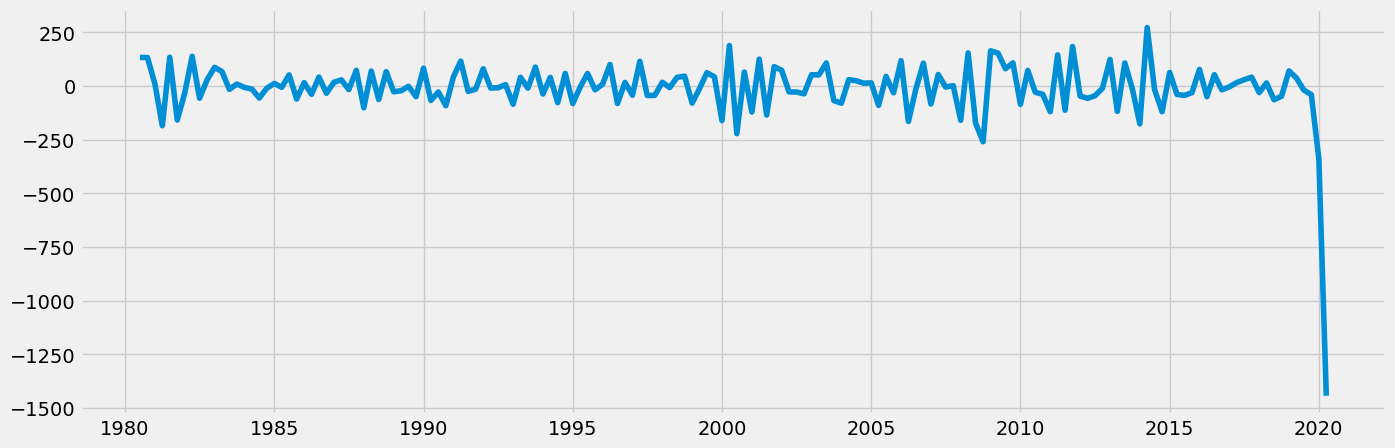

In [43]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [44]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -7.445561e+00
p-value                        5.851027e-11
Number of Lags Used            0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


##### Observations:
After performing the second round of differencing the data is now considered stationary. The test statistic is now smaller than the critical values.

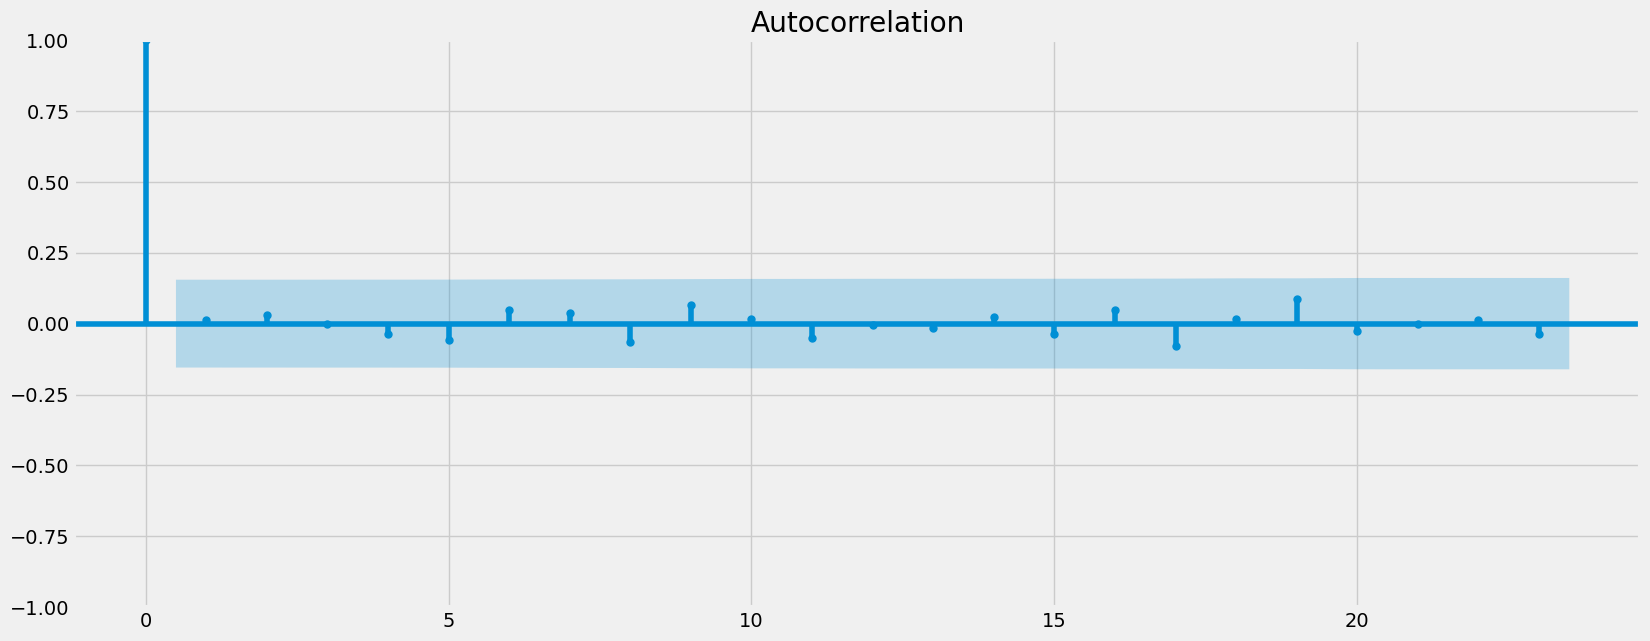

In [46]:
plot_acf(data_diff2)
plt.show()

##### Observations:
The autocorrelation plot has improved. However, even though the Dickey-Fuller test says the data is now stationary, the stationarity is weak.